## 🎮 Image Denoising via Game Theory 🎮

**Optimal filter selection through Nash equilibrium in mixed strategies**

### - Overview :
This project presents an innovative approach to image denoising by modeling the problem as a zero-sum game. We calculate the Nash equilibrium in mixed strategies to determine the optimal probabilistic distribution of denoising filters that guarantees robust performance against various noise types.

In [1]:
# Imports
%matplotlib inline
import cv2
import numpy as np
import os
from skimage.metrics import peak_signal_noise_ratio as psnr
import matplotlib.pyplot as plt
from collections import defaultdict
import random
import pandas as pd
import seaborn as sns
from scipy.optimize import linprog
sns.set_theme(style="whitegrid")

## Denoisers & Noises Definitions

In [2]:
class Denoiser:
    def denoise(self, image: np.ndarray) -> np.ndarray:
        raise NotImplementedError

class GaussianDenoiser(Denoiser):
    def denoise(self, image):
        return cv2.GaussianBlur(image, (5, 5), 1.5)

class NLMDenoiser(Denoiser):
    def denoise(self, image):
        return cv2.fastNlMeansDenoisingColored(
            image, None,
            h=10, hColor=30,
            templateWindowSize=7,
            searchWindowSize=21
        )

class MedianDenoiser(Denoiser):
    def denoise(self, image):
        return cv2.medianBlur(image, 5)

# Global lists 
NOISE_TYPES = [
    ("Gaussian", lambda image: np.clip(image.astype(np.float32) + np.random.normal(0, 25, image.shape), 0, 255).astype(np.uint8)),
    ("SaltPepper", lambda image: add_salt_pepper_noise(image, amount=0.02)),  # Define function below if needed
    ("Poisson", lambda image: np.clip(np.random.poisson(image.astype(np.float32) * 1.0) / 1.0, 0, 255).astype(np.uint8))
]

DENOISERS = [
    ("GaussianFilter", GaussianDenoiser()),
    ("MedianFilter", MedianDenoiser()),
    ("NLMFilter", NLMDenoiser())
]

# Helper function for Salt & Pepper 
def add_salt_pepper_noise(image, amount=0.02):
    noisy = image.copy()
    num_pixels = int(amount * image.shape[0] * image.shape[1])
    # Salt
    coords = (np.random.randint(0, image.shape[0], num_pixels), np.random.randint(0, image.shape[1], num_pixels))
    noisy[coords] = 255
    # Pepper
    coords = (np.random.randint(0, image.shape[0], num_pixels), np.random.randint(0, image.shape[1], num_pixels))
    noisy[coords] = 0
    return noisy

In [3]:
# Paths
BASE_DATASET_DIR = "datasetTHJ"
ORIGINAL_DIR = os.path.join(BASE_DATASET_DIR, "OG")
NOISY_DIR = os.path.join(BASE_DATASET_DIR, "noisy")
RESULTS_DIR = os.path.join(BASE_DATASET_DIR, "results_mixed")
os.makedirs(RESULTS_DIR, exist_ok=True)

## Building the Payoff Matrix

In [6]:
def build_payoff_matrix():
    """
    Construit une matrice de payoff (matrice de performance moyenne PSNR)
    où les lignes = types de bruit, colonnes = débruiteurs

    """
    psnr_scores = defaultdict(lambda: defaultdict(list)) #stocker les scrores PSNR 
    #psnr_scores[noise_idx][denoiser_idx] = liste de scores (un par image)
    
    #charger les images
    original_images = []
    for filename in os.listdir(ORIGINAL_DIR):
        if filename.lower().endswith((".png", ".jpg", ".jpeg")):
            image_path = os.path.join(ORIGINAL_DIR, filename)
            image = cv2.imread(image_path)
            if image is not None:
                original_images.append((filename, image))
    
    if not original_images:
        print("ERREUR: Aucune image trouvée.")
        return None, None
    
    total_combinations = len(original_images) * len(NOISE_TYPES) * len(DENOISERS)
    current_combination = 0

    #boucle principale : pour chaque image × chaque bruit × chaque débruiteur
    for img_idx, (img_name, original_img) in enumerate(original_images, 1):
        print(f"Processing image {img_idx}/{len(original_images)}: {img_name}")
        for noise_idx, (noise_name, noise_fn) in enumerate(NOISE_TYPES):
            noisy_img = noise_fn(original_img.copy()) #copie d'image
            for denoiser_idx, (denoiser_name, denoiser) in enumerate(DENOISERS):
                current_combination += 1
                # Application du débruiteur
                denoised_img = denoiser.denoise(noisy_img)
                # Conversion en niveaux de gris (PSNR souvent calculé en gris)
                # On gère le cas où l'image serait déjà en gris
                original_gray = cv2.cvtColor(original_img, cv2.COLOR_BGR2GRAY) if len(original_img.shape) == 3 else original_img
                denoised_gray = cv2.cvtColor(denoised_img, cv2.COLOR_BGR2GRAY) if len(denoised_img.shape) == 3 else denoised_img
                # Calcul du PSNR
                score = psnr(original_gray, denoised_gray, data_range=255)
                # Stockage du score individuel
                psnr_scores[noise_idx][denoiser_idx].append(score)

                print(f"  {noise_name} + {denoiser_name}: PSNR = {score:.2f} dB ({current_combination/total_combinations*100:.1f}%)")
    
    #construction de la matrice payoff
    payoff_matrix = np.zeros((3, 3))
    for noise_idx in range(3):
        for denoiser_idx in range(3):
            scores = psnr_scores[noise_idx][denoiser_idx]
            if scores:
                payoff_matrix[noise_idx][denoiser_idx] = np.mean(scores)
    
    df_payoff = pd.DataFrame(payoff_matrix, index=[n[0] for n in NOISE_TYPES], columns=[d[0] for d in DENOISERS])
    return df_payoff, psnr_scores

In [7]:
df_payoff, psnr_scores = build_payoff_matrix()
if df_payoff is not None:
    display(df_payoff.style.background_gradient(cmap='viridis')) 
    np.save("payoff_matrix.npy", df_payoff.values)  # Save as numpy

Processing image 1/30: 127215712_ff5b654d07_c.jpg
  Gaussian + GaussianFilter: PSNR = 27.72 dB (0.4%)
  Gaussian + MedianFilter: PSNR = 27.18 dB (0.7%)
  Gaussian + NLMFilter: PSNR = 25.84 dB (1.1%)
  SaltPepper + GaussianFilter: PSNR = 26.82 dB (1.5%)
  SaltPepper + MedianFilter: PSNR = 28.30 dB (1.9%)
  SaltPepper + NLMFilter: PSNR = 20.42 dB (2.2%)
  Poisson + GaussianFilter: PSNR = 28.46 dB (2.6%)
  Poisson + MedianFilter: PSNR = 28.09 dB (3.0%)
  Poisson + NLMFilter: PSNR = 31.93 dB (3.3%)
Processing image 2/30: 1286073711_06165cae4c_c.jpg
  Gaussian + GaussianFilter: PSNR = 25.73 dB (3.7%)
  Gaussian + MedianFilter: PSNR = 25.73 dB (4.1%)
  Gaussian + NLMFilter: PSNR = 25.53 dB (4.4%)
  SaltPepper + GaussianFilter: PSNR = 24.99 dB (4.8%)
  SaltPepper + MedianFilter: PSNR = 26.49 dB (5.2%)
  SaltPepper + NLMFilter: PSNR = 18.43 dB (5.6%)
  Poisson + GaussianFilter: PSNR = 26.48 dB (5.9%)
  Poisson + MedianFilter: PSNR = 26.43 dB (6.3%)
  Poisson + NLMFilter: PSNR = 33.00 dB (6.7%)

,GaussianFilter,MedianFilter,NLMFilter
Gaussian,28.232506,27.726584,26.670993
SaltPepper,26.928907,29.373704,19.796491
Poisson,29.256698,28.996195,32.702311


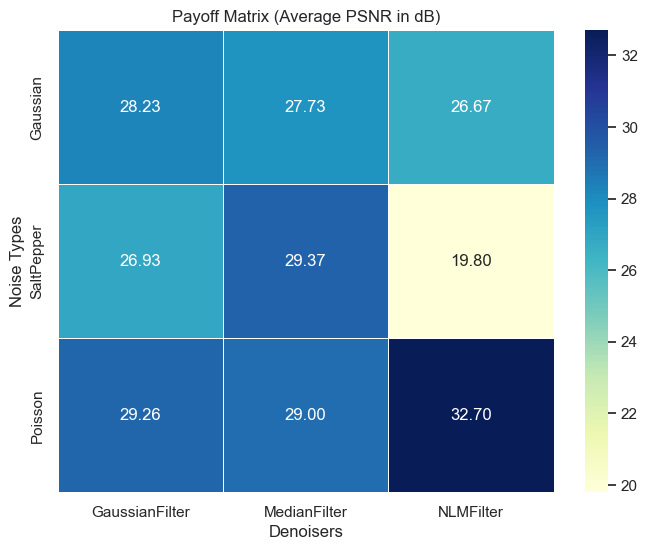

In [8]:
if df_payoff is not None:
    plt.figure(figsize=(8, 6))
    sns.heatmap(df_payoff, annot=True, fmt=".2f", cmap="YlGnBu", linewidths=0.5)
    plt.title("Payoff Matrix (Average PSNR in dB)")
    plt.xlabel("Denoisers")
    plt.ylabel("Noise Types")
    plt.show()

## Checking Pure Nash Equilibrium

In [9]:
def check_pure_nash(df_payoff):
    matrix = df_payoff.values #extraction de la matrice
    pure_nash_found = False
    nash_points = [] # liste de tuples (bruit, débruiteur, valeur)

    # On parcourt chaque case de la matrice
    for i in range(3):
        for j in range(3):
            # Condition 1 : le débruiteur (colonne) maximise son gain sur cette ligne
            # la valeur en (i,j) doit être la meilleure de toute la colonne j
            is_col_max = matrix[i][j] == np.max(matrix[:, j])

            # Condition 2 : le bruit (ligne) minimise le gain du débruiteur sur cette colonne
            # la valeur en (i,j) doit être la pire de toute la ligne i
            is_row_min = matrix[i][j] == np.min(matrix[i, :])
            if is_col_max and is_row_min:
                pure_nash_found = True
                nash_points.append((df_payoff.index[i], df_payoff.columns[j], matrix[i][j]))
    
    if pure_nash_found:
        df_nash = pd.DataFrame(nash_points, columns=["Noise", "Denoiser", "PSNR"])
        display(df_nash)
        print("Pure Nash Equilibrium found!")
    else:
        print("No Pure Nash Equilibrium found. Proceed to mixed strategy.")
    return pure_nash_found

In [10]:
if df_payoff is not None:
    check_pure_nash(df_payoff)

No Pure Nash Equilibrium found. Proceed to mixed strategy.


## Computing Mixed Nash Equilibrium

In [11]:
def compute_mixed_nash(matrix):
    """
    Calcule un équilibre de Nash mixte 
    en utilisant la programmation linéaire.

    - Ligne (minimiseur)  = le bruit = choisit le type de bruit
    - Colonne (maximiseur) = Débruiteur = choisit la méthode de débruitage
    - Payoff = PSNR moyen (plus élevé = meilleur pour le débruiteur)

    On résout DEUX problèmes de programmation linéaire :
      1. Pour le débruiteur (maximisation du gain minimum)
      2. Pour la nature (minimisation du gain maximum)

    Retourne :
        - p_star : probabilités optimales pour chaque débruiteur
        - q_star : probabilités optimales pour chaque type de bruit
        - v_star : valeur du jeu (PSNR espéré à l'équilibre)
    """
    n_noise, n_denoiser = matrix.shape
    
    # Stratégie du DÉBRUITEUR (joueur maximisant)
    # On cherche à maximiser v donc on minimise -v (linprog minimise par défaut)
    c = np.zeros(n_denoiser + 1) #coefs de la fonction objectif
    c[-1] = -1 # -v
    #pour chaque bruit i,  v  <=  somme_j p_j * matrix[i,j]
    # =  -somme_j p_j * matrix[i,j]  + v  <=  0
    A_ub = np.c_[-matrix.T, np.ones(n_noise)]
    b_ub = np.zeros(n_noise)

    # Somme des probabilités = 1
    A_eq = np.c_[np.ones((1, n_denoiser)), np.zeros(1)]
    b_eq = np.array([1])

    # Probabilités ≥ 0, v libre
    bounds = [(0, None)] * n_denoiser + [(None, None)]
    result_denoiser = linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')
    
    p_star = result_denoiser.x[:-1] if result_denoiser.success else None # probabilités des débruiteurs
    v_star = result_denoiser.x[-1] if result_denoiser.success else None  # valeur du jeu
    
    #Stratégie du bruit (joueur minimisant)
    #on cherche à minimiser u 
    c = np.zeros(n_noise + 1)
    c[-1] = 1 # u

    #pour chaque débruiteur j,  u  >=  somme_i q_i * matrix[i,j]
    # =  somme_i q_i * matrix[i,j]  - u  <=  0
    A_ub = np.c_[matrix, -np.ones(n_denoiser)]
    b_ub = np.zeros(n_denoiser)
    A_eq = np.c_[np.ones((1, n_noise)), np.zeros(1)]
    b_eq = np.array([1])
    bounds = [(0, None)] * n_noise + [(None, None)]
    result_nature = linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')
    
    q_star = result_nature.x[:-1] if result_nature.success else None # probabilités des bruits
    u_star = result_nature.x[-1] if result_nature.success else None
    
    # affichage
    if p_star is not None and q_star is not None:
        df_p = pd.DataFrame({"Denoiser": [d[0] for d in DENOISERS], "Probability": p_star})
        df_q = pd.DataFrame({"Noise": [n[0] for n in NOISE_TYPES], "Probability": q_star})
        display(df_p.style.format({"Probability": "{:.4f}"}))
        display(df_q.style.format({"Probability": "{:.4f}"}))
        print(f"Game Value: {v_star:.2f} dB")
        np.save('denoiser_strategy.npy', p_star)
        np.save('noise_strategy.npy', q_star)
    return p_star, q_star, v_star

In [12]:
if df_payoff is not None:
    matrix = df_payoff.values
    p_star, q_star, v_star = compute_mixed_nash(matrix)

,Denoiser,Probability
0,GaussianFilter,0.0000
1,MedianFilter,0.0963
2,NLMFilter,0.9037


,Noise,Probability
0,Gaussian,0.1395
1,SaltPepper,0.8605
2,Poisson,0.0000


Game Value: 29.03 dB


C:\Users\DELL\AppData\Local\Temp\ipykernel_14452\502700190.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[d[0] for d in DENOISERS], y=p_star * 100, ax=axes[0], palette="Blues_d")
C:\Users\DELL\AppData\Local\Temp\ipykernel_14452\502700190.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[n[0] for n in NOISE_TYPES], y=q_star * 100, ax=axes[1], palette="Oranges_d")


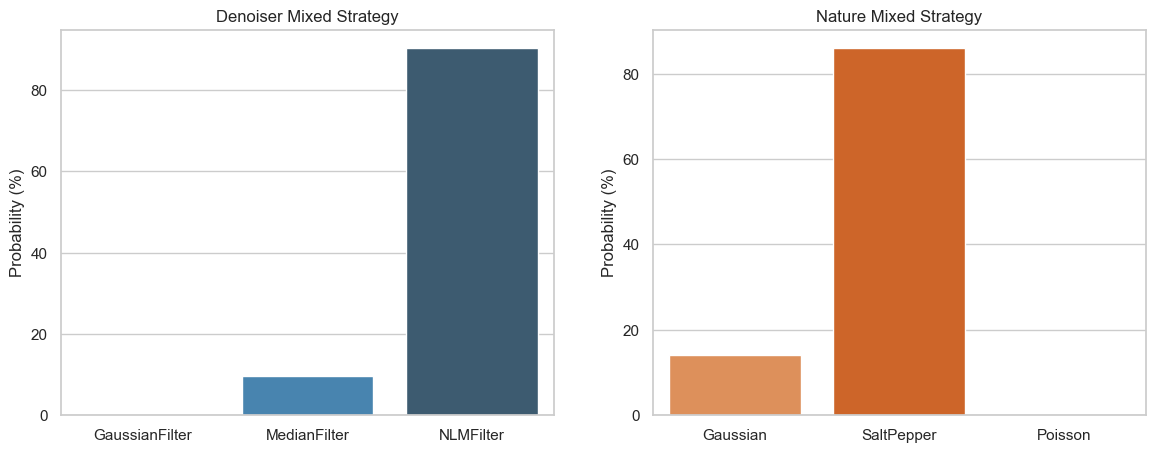

In [13]:
if p_star is not None and q_star is not None:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    sns.barplot(x=[d[0] for d in DENOISERS], y=p_star * 100, ax=axes[0], palette="Blues_d")
    axes[0].set_title("Denoiser Mixed Strategy")
    axes[0].set_ylabel("Probability (%)")
    sns.barplot(x=[n[0] for n in NOISE_TYPES], y=q_star * 100, ax=axes[1], palette="Oranges_d")
    axes[1].set_title("Nature Mixed Strategy")
    axes[1].set_ylabel("Probability (%)")
    plt.show()

## Comparing Strategies

,Strategy,Avg PSNR
0,GaussianFilter,28.139371
1,MedianFilter,28.698828
2,NLMFilter,26.389932
3,Mixed,26.612264


C:\Users\DELL\AppData\Local\Temp\ipykernel_14452\3635544569.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_compare, x="Strategy", y="Avg PSNR", palette="viridis")


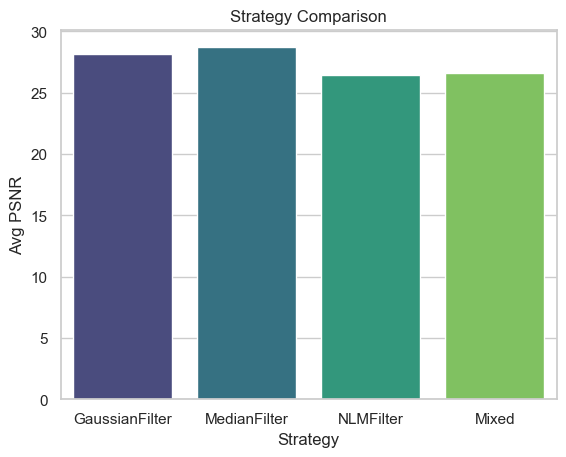

In [14]:
def compare_strategies(matrix, p_star):
    # PSNR espéré quand le débruiteur joue la stratégie mixte p_star
    # et que la nature (l’adversaire) joue sa pire stratégie possible
    #on suppose que la nature choisit les bruits uniformément
    pure_avgs = np.mean(matrix, axis=0)
    mixed_psnrs = np.dot(matrix.T, np.ones(3)/3) 
    df_compare = pd.DataFrame({
        "Strategy": [d[0] for d in DENOISERS] + ["Mixed"],
        "Avg PSNR": list(pure_avgs) + [np.mean(np.dot(p_star, matrix.T))]
    })
    display(df_compare.style.background_gradient(cmap='coolwarm'))
    sns.barplot(data=df_compare, x="Strategy", y="Avg PSNR", palette="viridis")
    plt.title("Strategy Comparison")
    plt.show()

compare_strategies(matrix, p_star)

## Applying Mixed Strategy to Noisy Images

In [15]:
def load_mixed_strategy():
    try:
        return np.load("denoiser_strategy.npy")
    except FileNotFoundError:
        print("denoiser_strategy.npy not found.")
        return None

def apply_mixed_denoising(image, p_star):
    """
    Applique la stratégie mixte de Nash sur une image donnée :
    - tire aléatoirement un débruiteur selon les probabilités p_star
    - applique ce débruiteur à l'image

    """
    choice = np.random.choice(len(DENOISERS), p=p_star)
    denoiser_name, denoiser = DENOISERS[choice]
    return denoiser.denoise(image), denoiser_name

def compute_psnr(original, denoised):
    """
    Calcule le PSNR entre l'image originale et l'image débruitée.

    """
    original_gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY) if len(original.shape) == 3 else original
    denoised_gray = cv2.cvtColor(denoised, cv2.COLOR_BGR2GRAY) if len(denoised.shape) == 3 else denoised
    return psnr(original_gray, denoised_gray, data_range=255)

In [16]:
def process_noisy_images(p_star):
    """
    Évalue les performances des débruiteurs (pures + mixte) sur un dossier d'images bruitées.
    
    Pour chaque image bruitée :
      - Applique tous les débruiteurs purs
      - Applique la stratégie mixte 
      - Calcule les PSNR par rapport à l'original correspondant
      - Crée et sauvegarde un montage visuel comparatif

    """
    psnr_scores = defaultdict(list)
    methods = [d[0] for d in DENOISERS] + ["Mixed"]
    
    noisy_files = [f for f in os.listdir(NOISY_DIR) if f.lower().endswith((".png", ".jpg", ".jpeg"))]
    if not noisy_files:
        print("No noisy images found.")
        return None
    
    for noisy_filename in noisy_files:
        base_name = '_'.join(noisy_filename.split('_')[:-2]) + os.path.splitext(noisy_filename)[1]
        original_path = os.path.join(ORIGINAL_DIR, base_name)
        if not os.path.exists(original_path):
            continue
        
        noisy_img = cv2.imread(os.path.join(NOISY_DIR, noisy_filename))
        original_img = cv2.imread(original_path)
        if noisy_img is None or original_img is None:
            continue
        
        # Pure strategies
        for denoiser_name, denoiser in DENOISERS:
            denoised = denoiser.denoise(noisy_img)
            score = compute_psnr(original_img, denoised)
            psnr_scores[denoiser_name].append(score)
        
        # Mixed
        mixed_denoised, chosen = apply_mixed_denoising(noisy_img, p_star)
        mixed_score = compute_psnr(original_img, mixed_denoised)
        psnr_scores["Mixed"].append(mixed_score)
        
        # Visual demo (montage)
        images = [original_img, noisy_img] + [d[1].denoise(noisy_img) for d in DENOISERS] + [mixed_denoised]
        titles = ["Original", "Noisy"] + [d[0] for d in DENOISERS] + [f"Mixed ({chosen})"]
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        for ax, img, title in zip(axes.flatten(), images, titles):
            ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            ax.set_title(title)
            ax.axis('off')
        plt.tight_layout()
        output_path = os.path.join(RESULTS_DIR, f"demo_{noisy_filename}.png")
        plt.savefig(output_path, dpi=300)
        plt.close()
        print(f"Saved demo: {output_path}")
    
    return psnr_scores

In [17]:
p_star = load_mixed_strategy()
if p_star is not None:
    psnr_scores = process_noisy_images(p_star)

Saved demo: datasetTHJ\results_mixed\demo_127215712_ff5b654d07_c_Poisson_scale1.0.jpg.png
Saved demo: datasetTHJ\results_mixed\demo_1286073711_06165cae4c_c_SaltPepper_amt0.02.jpg.png
Saved demo: datasetTHJ\results_mixed\demo_144839343_db2326a111_c_SaltPepper_amt0.02.jpg.png
Saved demo: datasetTHJ\results_mixed\demo_1751880610_cc095a05d3_c_Poisson_scale1.0.jpg.png
Saved demo: datasetTHJ\results_mixed\demo_2075863812_5b0a74e78e_c_Gaussian_sigma25.jpg.png
Saved demo: datasetTHJ\results_mixed\demo_2093410000_8d981b52fc_c_Poisson_scale1.0.jpg.png
Saved demo: datasetTHJ\results_mixed\demo_2155556592_002af287a7_c_Poisson_scale1.0.jpg.png
Saved demo: datasetTHJ\results_mixed\demo_220956201_bcf322a567_c_SaltPepper_amt0.02.jpg.png
Saved demo: datasetTHJ\results_mixed\demo_2242646767_e4b1e97410_c_Poisson_scale1.0.jpg.png
Saved demo: datasetTHJ\results_mixed\demo_2296844163_0f02ea244c_c_SaltPepper_amt0.02.jpg.png
Saved demo: datasetTHJ\results_mixed\demo_2312614472_572e87383f_c_Poisson_scale1.0.jp

,GaussianFilter,MedianFilter,NLMFilter,Mixed
count,30.00,30.00,30.00,30.00
mean,28.24,28.86,26.95,27.40
std,3.37,3.90,6.23,5.86
min,21.31,20.95,18.45,18.75
25%,25.57,26.51,20.18,20.65
50%,28.42,29.19,28.34,28.21
75%,30.75,30.93,32.52,32.73
max,36.71,37.93,36.29,36.29


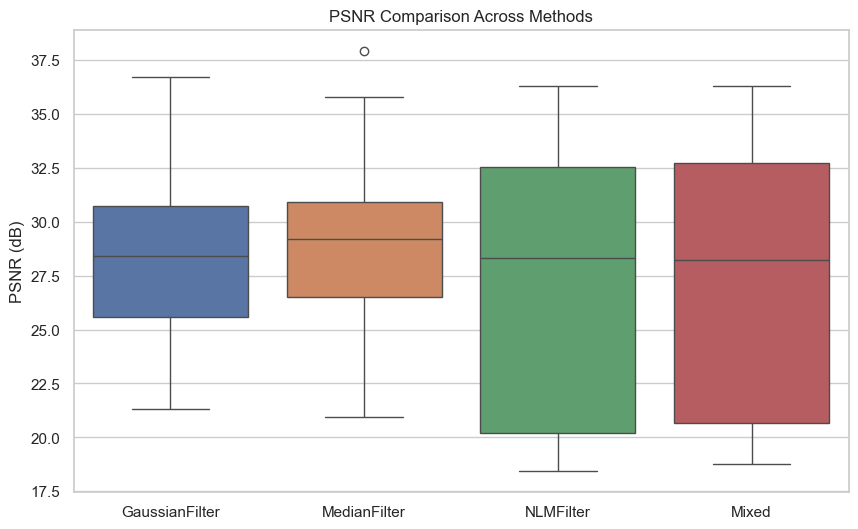

In [18]:
if psnr_scores:
    df_psnr = pd.DataFrame(psnr_scores)
    display(df_psnr.describe().style.format("{:.2f}"))  # Stats table
    
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df_psnr)
    plt.title("PSNR Comparison Across Methods")
    plt.ylabel("PSNR (dB)")
    plt.savefig(os.path.join(RESULTS_DIR, 'psnr_comparison.png'), dpi=300)
    plt.show()